In [25]:
# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
import pandas as pd
from os.path import join as pjoin
from glob import glob
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.externals.joblib import parallel_backend
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve


# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.vis as V
import util.helpers as H

# Normally, all libraries are loaded only once, 
# even if you execute the import code multiple times
# This code is helpful if you make your own helper libraries 
%load_ext autoreload
%autoreload 1
# list your libraries below with aimport: should ensure 
#they are reloaded each time without having to restart your kernel
# in this case, our libraries are used as an example

%aimport util.helpers, util.vis
%aimport features_extraction
%aimport augmentation
%aimport Analysis
%aimport validation
%aimport preprocessing
%aimport upsampling

# seed random generator such that this notebook always returns the same values 
# (this is by no means necessary, but it is useful for reproducability of results)
rng = np.random.RandomState(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# PATHS

DATA_DIR = '../data'
POSE_DIR = '../data/pose'

## Loading data
Loading all the training and test data

In [5]:
def keep_sample(sample):
    counter = 0
    no_hands_present = False
    for frame in sample:
        if (frame[4][0] == 0 or frame[7][0] == 0):
            counter += 1
        if (frame[4][0] == 0 and frame[7][0] == 0):
            no_hands_present = True
    if counter/len(sample) > 0.5 or no_hands_present:
        return False
    else:
        return True
##Loading all the training data
dataset_file=pjoin(DATA_DIR,'labels.csv')

train_samples=[]
train_labels=[]
train_persons = []
train_personlabels = []

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    sample_index = 0
    preprocessing_outliers = [229, 297, 1316, 1780, 1817, 49, 495, 541, 746, 878, 2910]
    outliers_jens_fixing_gap1 = [85 , 398 , 717 , 766 , 923 , 979 ,1111 ,1280 ,1671 ,1778 ,1960 ,1993 ,2038 ,2089, 2097, 2135 ,2140, 2145, 2417 ,2463 ,2554 ,2579, 2594, 2794, 2832 ,2975, 3138, 3211, 3215, 3325 ,3341 ,3396 ,3399 ,3482 ,3566, 3649, 3702]
    outliers_jens_fixing_gap2 = [264,322,578,592,663,717,766,770,885,888,894,901,906,917,923,933,949,954,964,979,986,1117,1151,1152,1159,1161,1171,1199,1227,1257,1297,1573,1600,1607,1665,1671,1684,1701,1767,1778,1831,1859,1883,1930,1931,1932,1943,1960,1972,1993,1999,2037,2050,2056,2060,2089,2091,2097,2106,2119,2135,2140,2167,2191,2209,2231,2232,2235,2260,2268,2289,2334,2336,2538,2551,2554,2579,2602,2614,2637,2683,2688,2694,2699,2726,2741,2787,2803,2810,2841,2844,2845,2848,2887,2888,2893,2902,2943,2947,2954,2967,2975,2984,2990,3037,3064,3073,3078,3087,3103,3118,3119,3136,3138,3149,3170,3283,3293,3298,3305,3332,3342,3435,3475,3482,3561,3589,3590,3621,3629,3641,3649,3658,3672,3693,3697,3699,3702,3709,3710]
    outliers_robbe_fixing_gap = [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245, 1846, 1909, 2435, 2545, 2590, 2815, 3515, 396, 421, 434, 494, 676, 718, 795, 815, 821, 882, 977, 991, 1016, 1035, 1111, 1295, 1308, 1524, 1564, 1586, 1633, 1634, 1804]
    #add [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118]
    for row in reader: 
        name, _gloss, label, _person = row
        sample = np.load(pjoin(POSE_DIR, 'train', name+'.npy'))
        #if (sample_index not in preprocessing_outliers) and (sample_index not in outliers_jens_fixing_gap1) and (sample_index not in outliers_jens_fixing_gap2) and (sample_index not in outliers_robbe_fixing_gap):            
        if keep_sample(sample):
            train_samples.append(sample)
            train_labels.append(int(label))
            train_persons.append(_person)
            train_personlabels.append((label, _person))
        sample_index += 1

train_samples=np.array(train_samples)
train_labels=np.array(train_labels)

##Loading all the test data
all_test_files = sorted(glob(pjoin(POSE_DIR, 'test', '*.npy')))  

test_samples = []
for numpy_file in all_test_files:
    sample = np.load(numpy_file)
    test_samples.append(sample)
    
test_samples = np.array(test_samples)

In [6]:
#Code to determine the outliers
temp = []
for i in range(len(train_samples)):
    teller = 0
    for frame in train_samples[i]:
        if (frame[4][0] == 0 or frame[7][0] == 0) and not(frame[4][0] == 0 and frame[7][0] == 0):
            teller += 1
    if teller/len(train_samples[i]) > 0.5:
        temp.append(i)
temp=np.unique(temp)
print((temp))

print(len(train_persons), len(train_samples))

[]
3560 3560


## Balancing the data with downsampling


In [ ]:
train_samples, train_labels, train_label_list, train_persons = upsampling.downsample(train_samples, train_labels, train_persons)
print(len(train_samples), len(train_labels), train_label_list)
print(train_samples[0].shape)

## Balancing the data with upsampling

In [7]:
upsampled_samples, upsampled_labels, upsampled_label_list, upsampled_persons = upsampling.upsample(train_samples, train_labels, train_persons, train_personlabels)
print(len(upsampled_samples), len(upsampled_labels), upsampled_label_list, len(upsampled_persons))
train_samples = upsampled_samples
train_labels = upsampled_labels
train_persons = upsampled_persons

6984 6984 [388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388] 6984


Text(0, 0.5, 'Number of samples')

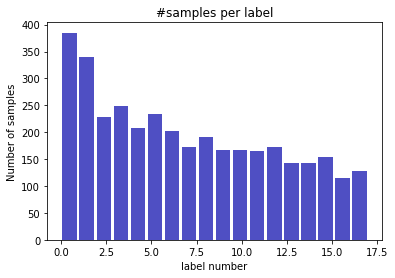

In [7]:
plt.hist(train_labels, bins = 18, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title("#samples per label")
plt.xlabel("label number")
plt.ylabel("Number of samples")

## Data augmentation

In [9]:
#train_samples = augmentation.augment_data(train_samples)
#train_labels = np.concatenate(( train_labels,train_labels, train_labels))
#train_persons = np.concatenate(( train_persons,train_persons, train_persons))
#train_personlabels = np.concatenate(( train_personlabels,train_personlabels, train_personlabels))

## Data preprocessing

In [8]:
train_samples = preprocessing.centering(train_samples)
test_samples = preprocessing.centering(test_samples)

--- Centering finished ---
--- Centering finished ---


In [9]:
## Extracting features

In [10]:
def extract_features(samples_list):
    # Calculate the average over time
    l = [np.mean(sample, axis=0) for sample in samples_list] 
    # Create a numpy array
    X = np.stack(l, axis=0)  
    # Reshape to (n_samples, n_features)
    X = X.reshape((len(samples_list), -1))                    
    return X


#X_train = extract_features(train_samples)
X_train = features_extraction.extract_features(train_samples).values
y_train = np.array(train_labels)
#X_test = extract_features(test_samples)
X_test = features_extraction.extract_features(test_samples).values
num_features = X_train.shape[1]
print(num_features) 
print(X_train.shape, y_train.shape)

D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\main\Documents\ML_competition\features_extraction.py:1243: RuntimeWarning: invalid value encountered in true_divide
  ve

869
(3560, 869) (3560,)


## Loss functions
Custom scoring functions

In [15]:
##Custom scoring functions

def top3_acc_score(y_true, proba):
    return H.mapk(proba,y_true)

def map3_score(y_true, proba):
    return H.top3_accuracy(proba, y_true)
    

acc = make_scorer(accuracy_score)
top3_acc = make_scorer(top3_acc_score, needs_proba=True) 
map3 = make_scorer(map3_score, needs_proba=True)
scoring_functions = {"acc": acc, "top3_acc": top3_acc, "map3": map3}

## Validation strategy

In [16]:
##Train validate data splitter for Cross Validation
seed = np.random.randint(1,999)
print("seed: ", seed)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

##Train validate data splitter for Cross Validation
gss = GroupShuffleSplit(n_splits = 6, test_size=0.2, random_state=0)
gss = gss.split(train_samples, train_labels, groups=train_persons)

seed:  833


## Pipeline & model training

In [72]:
# the function below generates our rescaled pipeline model
# with optimized regularisation parameter
def tune_randomForest(x_data,r_data,verbose=0):
    pipe = Pipeline([
        ('scale', StandardScaler()), 
        ('selectkbest', SelectKBest(f_classif)), 
        #('lda', LDA(n_components=18, solver = 'svd', shrinkage = None)), 
        ('forest', RandomForestClassifier(n_jobs=-1,random_state=84, class_weight="balanced"))
        ])

    # Set the parameters by cross-validation
    """
    tuned_parameters2 = {'forest__bootstrap': [False, True],
                        'forest__n_estimators': [110, 120, 130], #[80,90, 100, 110, 130],
                        'forest__max_features': [0.5, 0.6], #[0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
                        'forest__min_samples_leaf': [12, 14], #[10, 12, 14],
                        'forest__min_samples_split': [3, 4] #[3, 5, 7]
                        }
    """
    
    tuned_parameters = {'forest__bootstrap': [False, True],
                        'forest__n_estimators': np.arange(275, 285, 2),
                        'forest__max_depth': np.arange(7, 11, 1),
                        'forest__max_features': np.arange(0.75, 0.79, 0.01),
                        #'forest__min_samples_split': np.arange(56, 63, 3),
                        #'forest__min_samples_leaf': np.arange(32, 34, 1),
                        #'forest__max_leaf_nodes': np.arange(67, 72, 1),
                        'forest__min_weight_fraction_leaf': [0.1], 
                        'selectkbest__k': np.arange(200, 300, 10)}
    
    tuned_parameters = {'forest__bootstrap': [True],
                        'forest__n_estimators': [275], #np.arange(275, 285, 2),
                        'forest__max_depth': [5], #np.arange(7, 11, 1),
                        'forest__max_features': np.arange(0.05, 0.15, 0.1),
                        'forest__min_samples_split': [59], #np.arange(56, 63, 3),
                        'forest__min_samples_leaf': [33], #np.arange(32, 34, 1),
                        'forest__max_leaf_nodes':[67], # np.arange(67, 72, 1),
                        'forest__min_weight_fraction_leaf': [0.0], 
                        'selectkbest__k': np.arange(280, 300, 50)}
    
    print("------ Start tuning hyperparameters ------")
    CV = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=map3, refit=map3, pre_dispatch='n_jobs', cv=sgkf, verbose=2)
    CV = RandomizedSearchCV(pipe, tuned_parameters, n_iter = 100 ,n_jobs=-1, scoring=map3, refit=map3, pre_dispatch='n_jobs', cv=sgkf, verbose=2)

    with parallel_backend('threading'):
        CV.fit(x_data, r_data)
    print("------ Tuning hyperparameters finished ------")
    
    bestForestBootstrap = CV.best_params_['forest__bootstrap']
    bestForestEstimators = CV.best_params_['forest__n_estimators']
    bestForestFeatures = CV.best_params_['forest__max_features']
    bestForestLeaf = CV.best_params_['forest__min_samples_leaf']
    bestForestSplit = CV.best_params_['forest__min_samples_split']
    bestWeight = CV.best_params_['forest__min_weight_fraction_leaf']
    bestLeafNodes = CV.best_params_['forest__max_leaf_nodes']
    bestDepth = CV.best_params_['forest__max_depth']
    bestK = CV.best_params_['selectkbest__k']

    print("Optimal ForestBootstrap: ", bestForestBootstrap)
    print("Optimal ForestEstimators: ", bestForestEstimators)
    print("Optimal ForestFeatures: ", bestForestFeatures)
    print("Optimal ForestLeaf: ", bestForestLeaf)
    print("Optimal ForestSplit: ", bestForestSplit)
    print("Optimal Weight: ", bestWeight)
    print("Optimal Leaf Nodes: ", bestLeafNodes)
    print("Optimal Depth: ", bestDepth)
    print("Optimal k value: ", bestK)

    optimal_pipe = Pipeline([
        ('scale', StandardScaler()), 
        ('selectkbest', SelectKBest(f_classif, k=bestK)),
        #('pca', PCA(n_components=bestK)),
        #('lda', LDA(n_components=18, solver = 'svd', shrinkage = None)), 
        ('forest', RandomForestClassifier(n_jobs=-1, bootstrap=bestForestBootstrap,  n_estimators=bestForestEstimators,
                    max_features = bestForestFeatures, min_samples_leaf=bestForestLeaf, 
                    min_samples_split = bestForestSplit, max_depth = bestDepth, max_leaf_nodes = bestLeafNodes, 
                    min_weight_fraction_leaf = bestWeight, random_state=84, class_weight="balanced"))
                    ])
    
    if verbose>0:
    
        print("Grid scores on training data set:")
        print()
        cv_means = CV.cv_results_['mean_test_score']
        print(cv_means)
        cv_stds = CV.cv_results_['std_test_score']
        for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


    return optimal_pipe, CV.cv_results_

In [61]:
##Train validate data splitter for Cross Validation
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

print(sgkf)

<generator object stratified_group_k_fold at 0x000001C78055FB10>


In [29]:
clf = RandomForestClassifier(random_state = 84)

In [33]:
# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    ##Train validate data splitter for Cross Validation
    sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    print("busy with: ", parameter, num_range)
    #gss = GroupShuffleSplit(n_splits = 6, test_size=0.2, random_state=0)
    #gss = gss.split(train_samples, train_labels, groups=train_persons)
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range}, cv=sgkf, n_jobs=-1, scoring=map3, refit=map3, pre_dispatch='n_jobs')
    grid_search.fit(X_train, y_train)
    
    cv_results = grid_search.cv_results_
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    #scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    #scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    #for idx, val in enumerate(grid_param_2):
    ax.plot(num_range, scores_mean, '-o', label= parameter)

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(parameter, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    

In [36]:
# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(225, 300, 5),
              "max_depth": np.arange(2, 15, 1),
              "max_features": np.arange(0.65, 0.9, 0.02),
              "min_samples_split": np.arange(20,80,3),
              "min_samples_leaf": np.arange(20,50,2),
              "max_leaf_nodes": np.arange(30,80,2),
              "min_weight_fraction_leaf": np.arange(0.1,0.5, 0.1)}

busy with:  n_estimators [225 230 235 240 245 250 255 260 265 270 275 280 285 290 295]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  max_depth [ 2  3  4  5  6  7  8  9 10 11 12 13 14]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  max_features [0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83 0.85 0.87 0.89]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  min_samples_split [20 23 26 29 32 35 38 41 44 47 50 53 56 59 62 65 68 71 74 77]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  min_samples_leaf [20 22 24 26 28 30 32 34 36 38 40 42 44 46 48]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  max_leaf_nodes [30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76
 78]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


busy with:  min_weight_fraction_leaf [0.1 0.2 0.3 0.4]


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 1152x864 with 0 Axes>

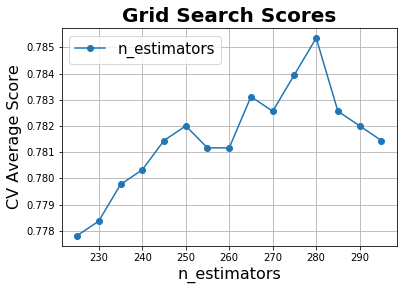

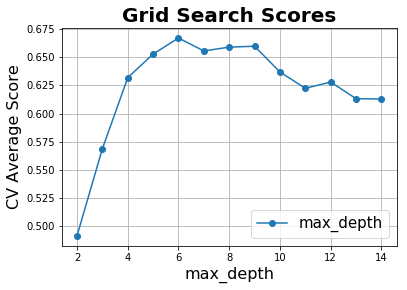

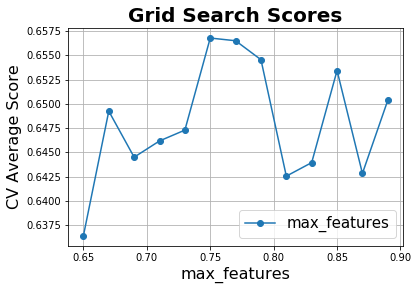

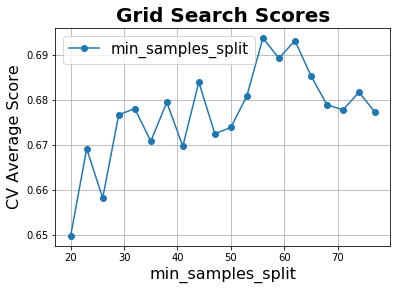

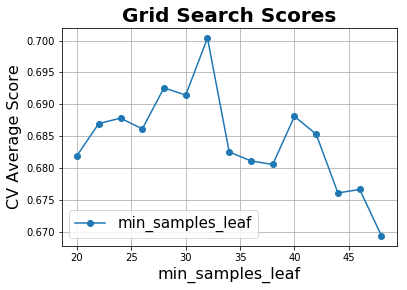

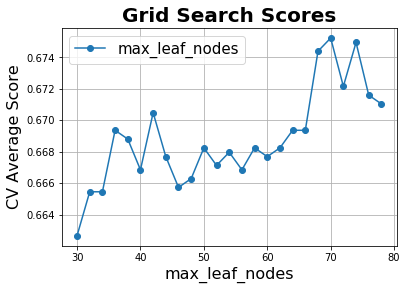

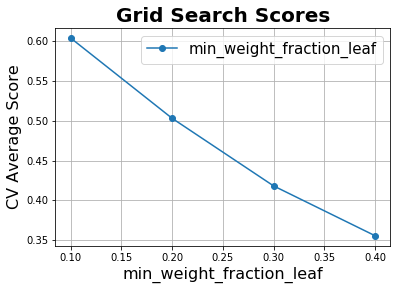

In [37]:
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

In [73]:
##Train validate data splitter for Cross Validation
gss = GroupShuffleSplit(n_splits = 6, test_size=0.2, random_state=0)
gss = gss.split(train_samples, train_labels, groups=train_persons)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
optimal_pipe, res = tune_randomForest(X_train, y_train, 1)

##Train validate data splitter for Cross Validation



------ Start tuning hyperparameters ------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True 
[CV] selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True 
[CV] selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True 
[CV] selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__m

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV]  selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True, total=   4.3s[CV]  selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True, total=   4.3s

[CV]  selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max_depth=5, forest__bootstrap=True, total=   4.3s
[CV]  selectkbest__k=280, forest__n_estimators=275, forest__min_weight_fraction_leaf=0.0, forest__min_samples_split=59, forest__min_samples_leaf=33, forest__max_leaf_nodes=67, forest__max_features=0.05, forest__max

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


------ Tuning hyperparameters finished ------
Optimal ForestBootstrap:  True
Optimal ForestEstimators:  275
Optimal ForestFeatures:  0.05
Optimal ForestLeaf:  33
Optimal ForestSplit:  59
Optimal Weight:  0.0
Optimal Leaf Nodes:  67
Optimal Depth:  5
Optimal k value:  280
Grid scores on training data set:

[0.74297753]
0.743 (+/-0.023) for {'selectkbest__k': 280, 'forest__n_estimators': 275, 'forest__min_weight_fraction_leaf': 0.0, 'forest__min_samples_split': 59, 'forest__min_samples_leaf': 33, 'forest__max_leaf_nodes': 67, 'forest__max_features': 0.05, 'forest__max_depth': 5, 'forest__bootstrap': True}


In [74]:
##Train validate data splitter for Cross Validation
gss = GroupShuffleSplit(n_splits = 6, test_size=0.2, random_state=0)
gss = gss.split(train_samples, train_labels, groups=train_persons)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

with parallel_backend('threading'):
    scores = cross_val_score(optimal_pipe, X_train, y_train, scoring=map3, cv=sgkf, n_jobs=-1, pre_dispatch='n_jobs')
print(scores)
print("Average (cross validated) map@3 score: ",scores.mean(),", stdev: ",scores.std())

optimal_pipe.fit(X_train, y_train)

[0.73399716 0.73961219 0.76502732 0.74099723 0.73421439]
Average (cross validated) map@3 score:  0.7427696572677525 , stdev:  0.011477492311485649


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=280, score_func=<function f_classif at 0x000001C7AEFDE400>)), ('forest', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=0...imators=275, n_jobs=-1, oob_score=False, random_state=84,
            verbose=0, warm_start=False))])

In [75]:
index_best_fit = 0
train_score_CV = [res['split0_train_score'][index_best_fit], res['split1_train_score'][index_best_fit], res['split2_train_score'][index_best_fit], res['split3_train_score'][index_best_fit], res['split4_train_score'][index_best_fit]]
val_score_CV = [res['split0_test_score'][index_best_fit], res['split1_test_score'][index_best_fit], res['split2_test_score'][index_best_fit], res['split3_test_score'][index_best_fit], res['split4_test_score'][index_best_fit]]
print("Train",train_score_CV, "averaged: ", np.mean(train_score_CV))
print("Val",val_score_CV, "averaged: ", np.mean(val_score_CV))

Train [0.8515925796289815, 0.8491895701198027, 0.8458274398868458, 0.854122621564482, 0.8454324418200764] averaged:  0.8492329306040377
Val [0.7339971550497866, 0.739612188365651, 0.7650273224043715, 0.7409972299168975, 0.7342143906020558] averaged:  0.7427696572677525


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are acc

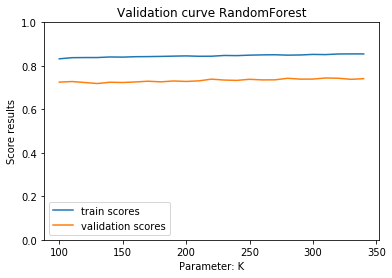

In [89]:
#with parallel_backend('threading'):
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scoresK, valid_scoresK = validation_curve(optimal_pipe, X_train, y_train, "selectkbest__k", np.arange(100, 350, 10), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')

valid_meansK = [np.mean(i) for i in valid_scoresK]
train_meansK = [np.mean(i) for i in train_scoresK]

plt.plot(np.arange(100, 350, 10), train_meansK, label="train scores")
plt.plot(np.arange(100, 350, 10), valid_meansK, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: K")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

In [107]:
with parallel_backend('threading'):
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scores, valid_scores = validation_curve(optimal_pipe, X_train, y_train, "forest__n_estimators", np.arange(100, 350, 10), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")
    sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    train_scores2, valid_scores2 = validation_curve(optimal_pipe, X_train, y_train, "forest__min_weight_fraction_leaf", np.arange(0, 0.51, 0.1), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scores3, valid_scores3 = validation_curve(optimal_pipe, X_train, y_train, "forest__min_samples_split", np.arange(40, 70, 3), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scores4, valid_scores4 = validation_curve(optimal_pipe, X_train, y_train, "forest__min_samples_leaf", np.arange(20, 50, 2), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")     
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scores5, valid_scores5 = validation_curve(optimal_pipe, X_train, y_train, "forest__max_leaf_nodes", np.arange(50, 72, 2), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")       
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed) 
    #train_scores6, valid_scores6 = validation_curve(optimal_pipe, X_train, y_train, "forest__max_features", np.arange(0.1, 0.99, 0.1), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")        
    #sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
    #train_scores7, valid_scores7 = validation_curve(optimal_pipe, X_train, y_train, "forest__max_depth", np.arange(1, 20, 1), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')
    print("=====Done=====")        

=====Done=====
=====Done=====
=====Done=====
=====Done=====
=====Done=====
=====Done=====
=====Done=====


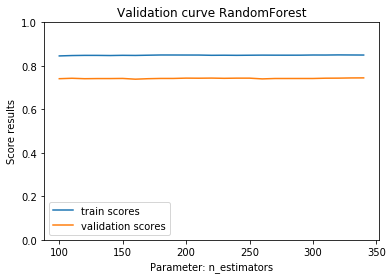

In [90]:
valid_means = [np.mean(i) for i in valid_scores]
train_means = [np.mean(i) for i in train_scores]

plt.plot(np.arange(100, 350, 10), train_means, label="train scores")
plt.plot(np.arange(100, 350, 10), valid_means, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: n_estimators")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

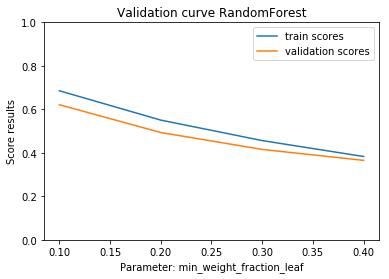

In [91]:
valid_means2 = [np.mean(i) for i in valid_scores2]
train_means2 = [np.mean(i) for i in train_scores2]

plt.plot(np.arange(0.1, 0.5, 0.1), train_means2, label="train scores")
plt.plot(np.arange(0.1, 0.5, 0.1), valid_means2, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: min_weight_fraction_leaf")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

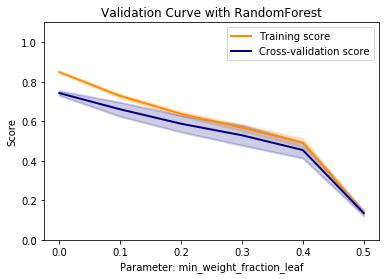

In [109]:
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(valid_scores2, axis=1)
test_scores_std = np.std(valid_scores2, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("Parameter: min_weight_fraction_leaf")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=np.arange(0, 0.51, 0.1)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

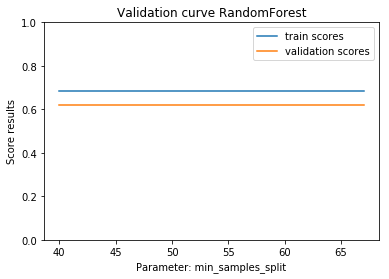

In [92]:
valid_means3 = [np.mean(i) for i in valid_scores3]
train_means3 = [np.mean(i) for i in train_scores3]

plt.plot(np.arange(40, 70, 3), train_means3, label="train scores")
plt.plot(np.arange(40, 70, 3), valid_means3, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: min_samples_split")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

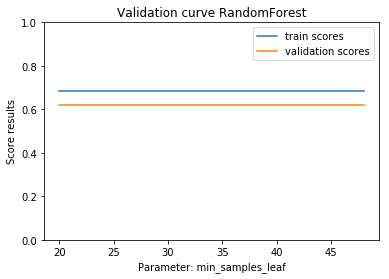

In [93]:
valid_means4 = [np.mean(i) for i in valid_scores4]
train_means4 = [np.mean(i) for i in train_scores4]

plt.plot(np.arange(20, 50, 2), train_means4, label="train scores")
plt.plot(np.arange(20, 50, 2), valid_means4, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: min_samples_leaf")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

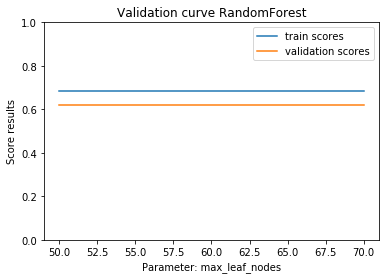

In [94]:
valid_means5 = [np.mean(i) for i in valid_scores5]
train_means5 = [np.mean(i) for i in train_scores5]

plt.plot(np.arange(50, 72, 2), train_means5, label="train scores")
plt.plot(np.arange(50, 72, 2), valid_means5, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: max_leaf_nodes")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

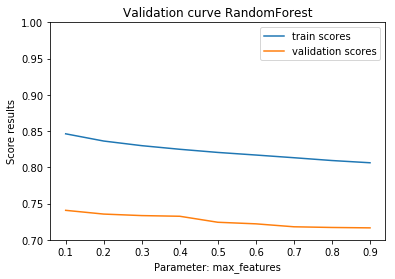

In [105]:
valid_means6 = [np.mean(i) for i in valid_scores6]
train_means6 = [np.mean(i) for i in train_scores6]

plt.plot(np.arange(0.1, 0.99, 0.1), train_means6, label="train scores")
plt.plot(np.arange(0.1, 0.99, 0.1), valid_means6, label="validation scores")
axes = plt.axes()
axes.set_ylim([0.7, 1])
plt.xlabel("Parameter: max_features")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

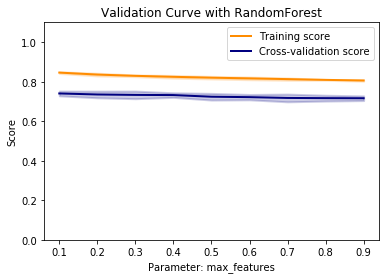

In [106]:
train_scores_mean = np.mean(train_scores6, axis=1)
train_scores_std = np.std(train_scores6, axis=1)
test_scores_mean = np.mean(valid_scores6, axis=1)
test_scores_std = np.std(valid_scores6, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("Parameter: max_features")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=np.arange(0.1, 0.99, 0.1)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

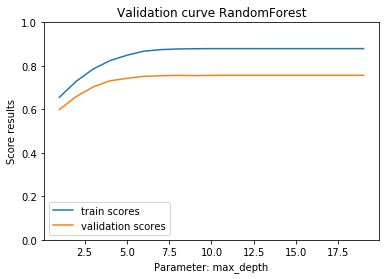

In [96]:
valid_means7 = [np.mean(i) for i in valid_scores7]
train_means7 = [np.mean(i) for i in train_scores7]

plt.plot(np.arange(1, 20, 1), train_means7, label="train scores")
plt.plot(np.arange(1, 20, 1), valid_means7, label="validation scores")
axes = plt.axes()
axes.set_ylim([0, 1])
plt.xlabel("Parameter: max_depth")
plt.ylabel("Score results")
plt.title("Validation curve RandomForest")
plt.legend()

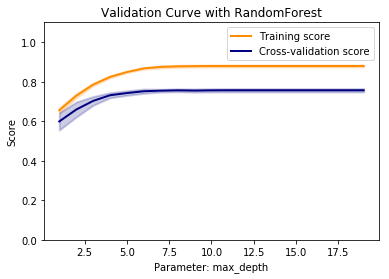

In [103]:
train_scores_mean = np.mean(train_scores7, axis=1)
train_scores_std = np.std(train_scores7, axis=1)
test_scores_mean = np.mean(valid_scores7, axis=1)
test_scores_std = np.std(valid_scores7, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("Parameter: max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=np.arange(1, 20, 1)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Generate kaggle submission file

In [110]:
test_probas = optimal_pipe.predict_proba(X_test)
H.create_submission(test_probas, 'RandomForestTuned.csv')

## Model analysis
Generate confusion matrix on validation data

In [143]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
##Train validate data splitter for Cross Validation
gss = GroupShuffleSplit(n_splits = 6, test_size=0.2, random_state=0)
gss = gss.split(train_samples, train_labels, groups=train_persons)
with parallel_backend('threading'):
    y_pred = cross_val_predict(optimal_pipe, X_train, y_train, cv=gskf, n_jobs=-1, pre_dispatch='n_jobs')
Analysis.plot_confusion_matrix(confusion_matrix(y_train, y_pred))

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
 

ValueError: cross_val_predict only works for partitions

Calculate the precision, recall, F1 score, TP, FP and NP

In [144]:
##ANALYSIS

#PLOTS
P,R,F1 = None,None,None # compute these for class c on the TEST SET

#ORDER PROBABILITIES
prob_order = H.get_ordered_predictions(train_probas)
# Get the top prediction per sample.
top_prob = prob_order[:,:1]
top_prob_2= prob_order[:,1:2]
top_prob_3= prob_order[:,2:3]

#PRECISION,RECALL,F1 PER CLASS
print("--- TEST SET ---")
macro_f1 = 0 
for c in range(0,18):
    print("Class :{}".format(c))
    print('------')
    for k in range(1,4):
        print("k :{}".format(k))
        P,R,F1 = None,None,None # compute these for class c on the TEST SET
        # YOUR CODE HERE
        P,R,F1,TP,FP,FN = Analysis.compute_precision_recall_F1_label(train_probas, y_train, k,c)
        #raise NotImplementedError()
        if F1!=0.0:
            macro_f1 += F1
        
        print("Number of TP,FP,FN:")
        print('TP in k{} for class {}:{}'.format(k,c,TP))
        print('FP in k{} for class {}:{}'.format(k,c,FP))
        print('FN in k{} for class {}:{}'.format(k,c,FN))
        print("------")
        print('Precision K:{} for class {}: {}'.format(k,c,P))
        print('Recall K:{} for class    {}: {}'.format(k,c,R))
        print('F1 K:{} for class        {}: {}'.format(k,c,F1))
        
    print('-----------------------------')
        
        
macro_f1 /= 3        

print(f'F1: {macro_f1}')

NameError: name 'train_probas' is not defined